# TARA MicV Temperature
## Figure 4
### Modelling ROC curves
**David Demory and Hisashi Endo -- 17 Oct. 2024**

## Setup the environment

In [1]:
## Workspace
rm(list = ls())
workdir = "../" #set your path to the folder "Demory_Endo_Temperature_MicV_biogeography"
setwd(workdir)
#getwd()

In [3]:
## load libraries
library(ggplot2)
library(dplyr)
library(reshape2)
library(pROC)
library(gridExtra)
library(grid)

In [4]:
## Load viral "OTU" information datasets
info.V <- read.csv("./data/Info_Virus_New2023.txt", sep="")
head(info.V)

,query.acc.ver,subject.acc.ver,X..identity,alignment.length,mismatches,gap.opens,q.start,q.end,s.start,s.end,evalue,bit.score,strain.V,sp.V,phylotype
,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>
4,KP734132.1,TARA_067_SRF_0.45-0.8_G_scaffold219644_1_gene229127,98.878,624,7,0,1,624,1384,2007,0,1114,4224,MicV-C,NA
5,KP734141.1,TARA_067_SRF_0.45-0.8_G_scaffold219644_1_gene229127,99.191,618,5,0,7,624,1390,2007,0,1114,4225,MicV-C,NA
6,KP734135.1,TARA_067_SRF_0.45-0.8_G_scaffold219644_1_gene229127,99.065,642,6,0,1,642,1390,2031,0,1153,4226,MicV-C,NA
7,KP734130.1,TARA_067_SRF_0.45-0.8_G_scaffold219644_1_gene229127,97.782,496,10,1,1,495,1458,1953,0,854,4228,MicV-C,NA
8,KP734133.1,TARA_067_SRF_0.45-0.8_G_scaffold219644_1_gene229127,98.878,624,7,0,1,624,1384,2007,0,1114,4229,MicV-C,NA
9,KP734131.1,TARA_067_SRF_0.45-0.8_G_scaffold219644_1_gene229127,98.276,580,10,0,1,580,1378,1957,0,1016,4230,MicV-C,NA


In [5]:
## Load virus groups frequency tables
## Major Clades 
MicV.A <- read.csv("./data/df_MicV_A_merge_stdz.txt", sep="")
com.A <- MicV.A[17:ncol(MicV.A)]
totcom.A <- rowSums(com.A)

MicV.C <- read.csv("./data/df_MicV_C_merge_stdz.txt", sep="")
com.C <- MicV.C[17:ncol(MicV.C)]
totcom.C <- rowSums(com.C)

MicV.B <- read.csv("./data/df_MicV_B_merge_stdz.txt", sep="")
com.B <- MicV.B[17:ncol(MicV.B)]
totcom.B <- rowSums(com.B)

MicV.Pol <- read.csv("./data/df_MicV_Pol_merge_stdz.txt", sep="")
com.Pol <- MicV.Pol[17:ncol(MicV.Pol)]
totcom.Pol <- rowSums(com.Pol)

## Minor Clades
MicV.A1 <- read.csv("./data/df_MicV_A1_merge_stdz.txt", sep="")
com.A1 <- MicV.A1[17:ncol(MicV.A1)]
totcom.A1 <- rowSums(com.A1)

MicV.A2 <- read.csv("./data/df_MicV_A2_merge_stdz.txt", sep="")
com.A2 <- MicV.A2[17:ncol(MicV.A2)]
totcom.A2 <- rowSums(com.A2)

MicV.Pol1 <- read.csv("./data/df_MicV_Pol1_merge_stdz.txt", sep="")
com.Pol1 <- MicV.Pol1[17:ncol(MicV.Pol1)]
totcom.Pol1 <- rowSums(com.Pol1)

MicV.Pol2 <- read.csv("./data/df_MicV_Pol2_merge_stdz.txt", sep="")
com.Pol2 <- MicV.Pol2[17:ncol(MicV.Pol2)]
totcom.Pol2 <- rowSums(com.Pol2)

MicV.B1 <- read.csv("./data/df_MicV_B1_merge_stdz.txt", sep="")
com.B1 <- MicV.B1[17:ncol(MicV.B1)]
totcom.B1 <- rowSums(com.B1)

MicV.B2 <- read.csv("./data/df_MicV_B2_merge_stdz.txt", sep="")
com.B2 <- MicV.B2[17:ncol(MicV.B2)]
totcom.B2 <- rowSums(com.B2)

## Model 
from Demory et al. Ecology Letters 2021

In [6]:
## Parameters
paraA <- c(1.1748E10,6757.8,1.1964E25,17354,1E9,1.037E-6,320.38,0.057292,
           1.0137E22,13120,1.6265E22,13261,17.182,292.12,4.291,1.1388E19,
           0.01508,1.5207,1E-8)
  
paraB <- c(1e+10,6745.1,1e+25,17335,1000000000,1.2e-06,313.15,0.15195,1.0138e+22,
           13119,1.6256e+22,13264,17,297.86,8.937,1.3859e+19,1.405964e+16,
           11542.69,1.9217e-08)

paraC <- c(9372875957,6812.273,8.533459e+24,17374.71,11000000,1.030034e-06,333.4005,
           0.1471658,1.015882e+22,13120.93,1.64207e+22,13264.53,118.6584,301.1302,
           3.0023,5.181019e+18,0.0608461,4.000002,8.981109e-10)

paraPol <- c(1E11,7260.7,1.998E24,16296,1E10,2.6279e-07,291.83,
             0.1,2.0983E09,5705.3,3.0485E24,16007,99.534,280.5,
             9.2464,5.0254E22,0.49447,0.47675,1.489e-10)

Tdrivenf <- function(T,Chla,para){
  
  TK = T+273.15
  nChla=Chla/max(Chla,na.rm = TRUE)
  
  # --- Growth and basal mortality ---
  A1 = para[1]
  E1 = para[2]
  A2 = para[3]
  E2 = para[4]
  f = A1*exp(-E1/TK)
  g = A2*exp(-E2/TK)
  mu = f
  psi = g
  mu_net = f-g
  mu_net[mu_net<0]=0
  # --- Carrying capacity ---
  K = para[5]
  nK = nChla*K
  
  # --- Viral adsorption ---
  phiK = para[6]
  Tphi = para[7]
  phir = para[8]
  numA = phiK
  denA = phiK+exp(-phir*(TK-Tphi))
  phi = numA/denA
  
  ## --- Lysis rate ---
  s1 = para[9]
  d1 = para[10]
  s2 = para[11]
  d2 = para[12]
  f = s1*exp(-d1/TK)
  g = s2*exp(-d2/TK)
  eta = f - g
  eta[eta<0] = 0
  
  ## --- Burst size ---
  b1 = para[13]
  beta = b1*(f-g)
  beta[beta<0] = 0
  
  ## --- production of noninfectious viruses
  epsK = 1
  Teps = para[14]
  epsr = para[15]
  epsilon = epsK/(1+exp((-d2/TK)*(1-(Teps/TK)))^epsr)
  
  ## --- viral lost of infectivity ---
  sig1 = para[16]
  sigma = sig1*exp(-d2/TK)
  
  ## --- viral degradation ---
  #delta parameters
  del1 = para[17]
  del2 = para[18]
  delta = del1*exp(-del2/TK)
  
  # --- viral aggregation ---
  omega = para[19]
  
  # --- Seq ---
  Seq = (1-(psi/mu_net))*K
  Seq[Seq<0]=0
  nSeq = (1-(psi/mu_net))*nK
  nSeq[nSeq<0]=0
  
  # --- R0_Ecol ---
  R0 = ((1-epsilon)*beta*eta*phi*Seq)/((sigma+phi*Seq)*(eta+psi))
  nR0 = ((1-epsilon)*beta*eta*phi*nSeq)/((sigma+phi*nSeq)*(eta+psi))
  
  # --- Vir_prod ---
  Ninf = phi*Seq
  nNinf = phi*nSeq
  probaL = eta/(eta+psi)
  Vprod = beta*probaL*Ninf
  nVprod = beta*probaL*nNinf
  probA = phi*Seq/(phi*Seq+sigma)

  R0[R0<=1]=0;
  R0[R0>1]=1;
  fT = data.frame("Temperature"=T,"probaL"=probaL,"R0"=R0,
                  "probaA"=probA)
  
  return(fT)
}

## ROC major grps

In [7]:
### GROUPE A

# Presence table
MicV.A.Presence <- rep('NA',length(totcom.A))
MicV.A.Presence[totcom.A > 0.0]=1
MicV.A.Presence[totcom.A <= 0.0]=0

# ROC data
mod <- Tdrivenf(MicV.A$Temperature,MicV.A$ChlorophyllA,paraA)
MicV.Presence = MicV.A.Presence
T<-MicV.A$Temperature

# ROC
ROC.STAT.A = data.frame()
for (x in 2:length(mod)) {
  roc_obj <- roc(MicV.Presence,mod[,x],na.rm=TRUE,levels=c(1,0),percent=TRUE, ci=TRUE)
  accuracy  = max(coords(roc_obj, x = "best", ret = "accuracy"))
  precision = max(coords(roc_obj, x = "best", ret = "precision"))
  recall    = max(coords(roc_obj, x = "best", ret = "recall"))
  F1.Score  = (2*precision*recall)/(precision+recall)
  F1.Score2 = 2/(1/precision + 1/recall)
  AUC       = auc(roc_obj)[1]
  stat = data.frame("parameters"=colnames(mod)[x],"Accuracy"=accuracy,"Precision"=precision,"Recall"=recall,"F1 Score"=F1.Score,"AUC"=AUC)
  ROC.STAT.A = rbind(ROC.STAT.A, stat)
}
print(ROC.STAT.A)
# > 70% is good.
# Notes: R0 here is binary (> or < to 1), then it is not relevant for the ROC analysis

# Data for plot
roc.obj.A.probaL <- roc(MicV.Presence,mod[,2],na.rm=TRUE,levels=c(1,0),percent=TRUE, ci=TRUE)
roc.obj.A.probaA <- roc(MicV.Presence,mod[,4],na.rm=TRUE,levels=c(1,0),percent=TRUE, ci=TRUE)

Setting direction: controls > cases

Setting direction: controls > cases

Setting direction: controls > cases



  parameters Accuracy Precision   Recall F1.Score      AUC
1     probaL 73.00885  48.91304 76.27119 59.60265 77.67685
2         R0 72.12389  47.77778 72.88136 57.71812 72.36882
3     probaA 73.00885  48.91304 76.27119 59.60265 78.42789


Setting direction: controls > cases

Setting direction: controls > cases



In [28]:
### GROUPE B

# Presence table
MicV.B.Presence <- rep('NA',length(totcom.B))
MicV.B.Presence[totcom.B > 0.0]=1
MicV.B.Presence[totcom.B <= 0.0]=0

# ROC data
mod <- Tdrivenf(MicV.B$Temperature,MicV.B$ChlorophyllA,paraB)
MicV.Presence = MicV.B.Presence
T<-MicV.B$Temperature

# ROC
ROC.STAT.B = data.frame()
for (x in 2:length(mod)) {
  roc_obj <- roc(MicV.Presence,mod[,x],na.rm=TRUE,levels=c(1,0),percent=TRUE, ci=TRUE)
  accuracy  = max(coords(roc_obj, x = "best", ret = "accuracy"))
  precision = max(coords(roc_obj, x = "best", ret = "precision"))
  recall    = max(coords(roc_obj, x = "best", ret = "recall"))
  F1.Score  = (2*precision*recall)/(precision+recall)
  F1.Score2 = 2/(1/precision + 1/recall)
  AUC       = auc(roc_obj)[1]
  stat = data.frame("parameters"=colnames(mod)[x],"Accuracy"=accuracy,"Precision"=precision,"Recall"=recall,"F1 Score"=F1.Score,"AUC"=AUC)
  ROC.STAT.B = rbind(ROC.STAT.B, stat)
}
print(ROC.STAT.B)
# > 95% is excelent

# Data for plot\
roc.obj.B.probaL <- roc(MicV.Presence,mod[,2],na.rm=TRUE,levels=c(1,0),percent=TRUE, ci=TRUE)
roc.obj.B.probaA <- roc(MicV.Presence,mod[,4],na.rm=TRUE,levels=c(1,0),percent=TRUE, ci=TRUE)

Setting direction: controls > cases

Setting direction: controls < cases

Setting direction: controls > cases



  parameters Accuracy Precision    Recall F1.Score      AUC
1     probaL 95.13274  96.68874  96.05263 96.36964 98.02632
2         R0 67.25664       NaN 100.00000      NaN 43.42105
3     probaA 95.13274  96.68874  96.05263 96.36964 98.02632


Setting direction: controls > cases

Setting direction: controls > cases



In [9]:
### GROUPE C

# Presence table
MicV.C.Presence <- rep('NA',length(totcom.C))
MicV.C.Presence[totcom.C > 0.0]=1
MicV.C.Presence[totcom.C <= 0.0]=0

# ROC data
mod <- Tdrivenf(MicV.C$Temperature,MicV.C$ChlorophyllA,paraC)
MicV.Presence = MicV.C.Presence
T<-MicV.C$Temperature

# ROC
ROC.STAT.C = data.frame()
for (x in 2:length(mod)) {
  roc_obj <- roc(MicV.Presence,mod[,x],na.rm=TRUE,levels=c(1,0),percent=TRUE, ci=TRUE)
  accuracy  = max(coords(roc_obj, x = "best", ret = "accuracy"))
  precision = max(coords(roc_obj, x = "best", ret = "precision"))
  recall    = max(coords(roc_obj, x = "best", ret = "recall"))
  F1.Score  = (2*precision*recall)/(precision+recall)
  F1.Score2 = 2/(1/precision + 1/recall)
  AUC       = auc(roc_obj)[1]
  stat = data.frame("parameters"=colnames(mod)[x],"Accuracy"=accuracy,"Precision"=precision,"Recall"=recall,"F1 Score"=F1.Score,"AUC"=AUC)
  ROC.STAT.C = rbind(ROC.STAT.C, stat)
}
print(ROC.STAT.C)
# probaL at 69% is good but probaA not good. Here we have really few points that are positives in the data so it is not really a good dataset

Per.of.Positive.TARA = (length(MicV.Presence[MicV.Presence==1])*100)/length(MicV.Presence)
Per.of.Positive.TARA
length(MicV.Presence)
# On 228 samples we only have 4.4% of them where we found C viruses, that is about 10 stations.

# Data for plot
roc.obj.C.probaL <- roc(MicV.Presence,mod[,2],na.rm=TRUE,levels=c(1,0),percent=TRUE, ci=TRUE)
roc.obj.C.probaA <- roc(MicV.Presence,mod[,4],na.rm=TRUE,levels=c(1,0),percent=TRUE, ci=TRUE)

Setting direction: controls > cases

Setting direction: controls < cases

Setting direction: controls > cases



  parameters Accuracy Precision    Recall F1.Score      AUC
1     probaL 50.44248       100  48.14815       65 68.77315
2         R0 95.57522       NaN 100.00000      NaN 35.41667
3     probaA 50.44248       100  48.14815       65 68.77315


[1] 4.385965

[1] 228

Setting direction: controls > cases

Setting direction: controls > cases



In [11]:
### GROUPE Pol

# Presence table
MicV.Pol.Presence <- rep('NA',length(totcom.Pol))
MicV.Pol.Presence[totcom.Pol > 0.0]=1
MicV.Pol.Presence[totcom.Pol <= 0.0]=0

# ROC data
mod <- Tdrivenf(MicV.Pol$Temperature,MicV.Pol$ChlorophyllA,paraPol)
MicV.Presence = MicV.Pol.Presence
T<-MicV.Pol$Temperature

# ROC
ROC.STAT.Pol = data.frame()
for (x in 2:length(mod)) {
  roc_obj <- roc(MicV.Presence,mod[,x],na.rm=TRUE,levels=c(1,0),percent=TRUE, ci=TRUE)
  accuracy  = max(coords(roc_obj, x = "best", ret = "accuracy"))
  precision = max(coords(roc_obj, x = "best", ret = "precision"))
  recall    = max(coords(roc_obj, x = "best", ret = "recall"))
  F1.Score  = (2*precision*recall)/(precision+recall)
  F1.Score2 = 2/(1/precision + 1/recall)
  AUC       = auc(roc_obj)[1]
  stat = data.frame("parameters"=colnames(mod)[x],"Accuracy"=accuracy,"Precision"=precision,"Recall"=recall,"F1 Score"=F1.Score,"AUC"=AUC)
  ROC.STAT.Pol = rbind(ROC.STAT.Pol, stat)
}
print(ROC.STAT.Pol)
# > 85% is excelent

# Data for plot
roc.obj.Pol.probaL <- roc(MicV.Presence,mod[,2],na.rm=TRUE,levels=c(1,0),percent=TRUE, ci=TRUE)
roc.obj.Pol.probaA <- roc(MicV.Presence,mod[,4],na.rm=TRUE,levels=c(1,0),percent=TRUE, ci=TRUE)


Setting direction: controls > cases

Setting direction: controls > cases

Setting direction: controls > cases



  parameters Accuracy Precision   Recall F1.Score      AUC
1     probaL 91.15044  93.58974 93.58974 93.58974 94.13462
2         R0 91.59292  91.01796 97.43590 94.11765 88.00366
3     probaA 91.15044  93.58974 93.58974 93.58974 91.55678


Setting direction: controls > cases

Setting direction: controls > cases



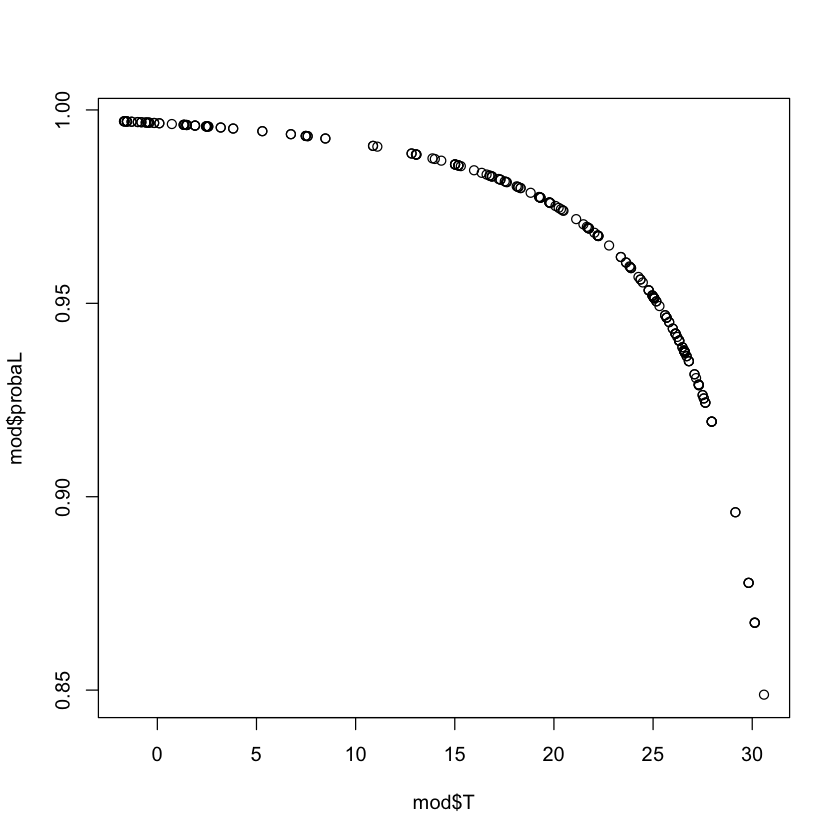

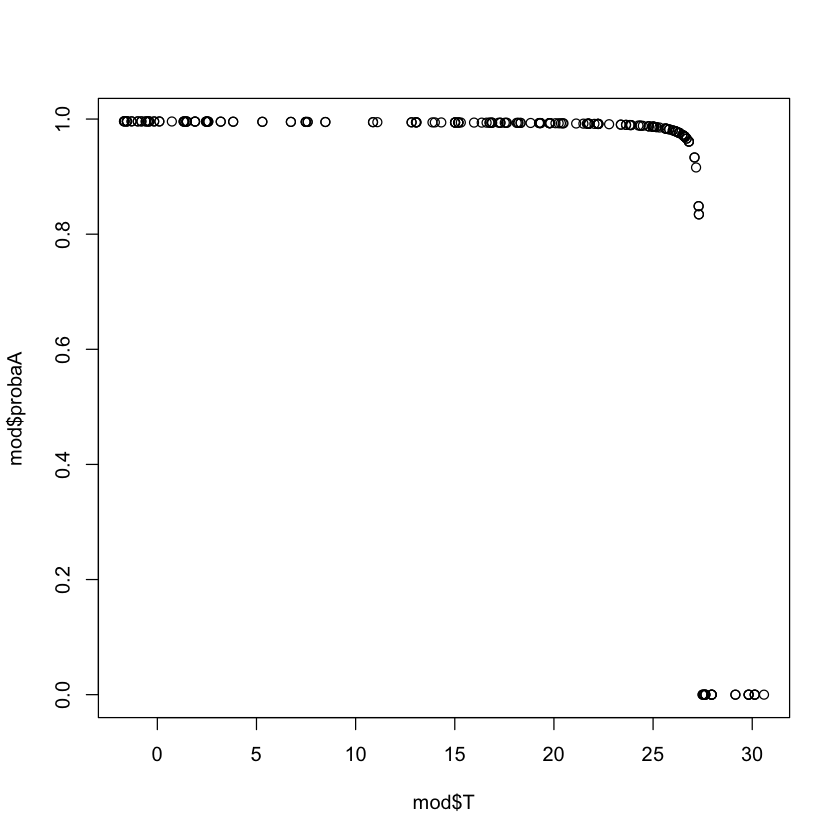

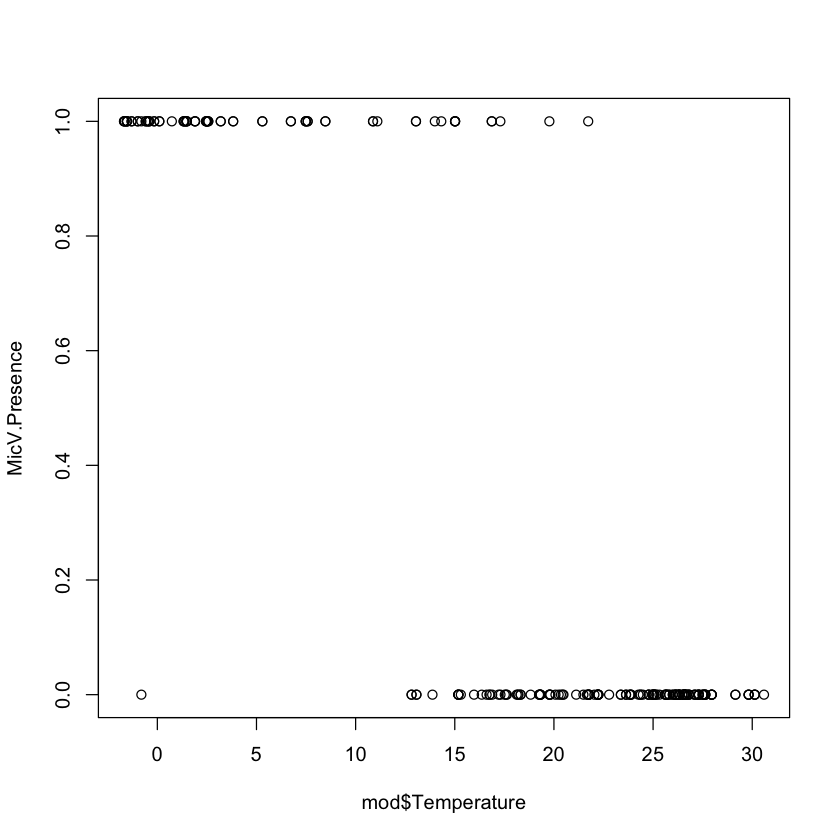

In [36]:
plot(mod$T,mod$probaL)
plot(mod$T,mod$probaA)
plot(mod$Temperature,MicV.Presence)

### PLOT ROC CURVES

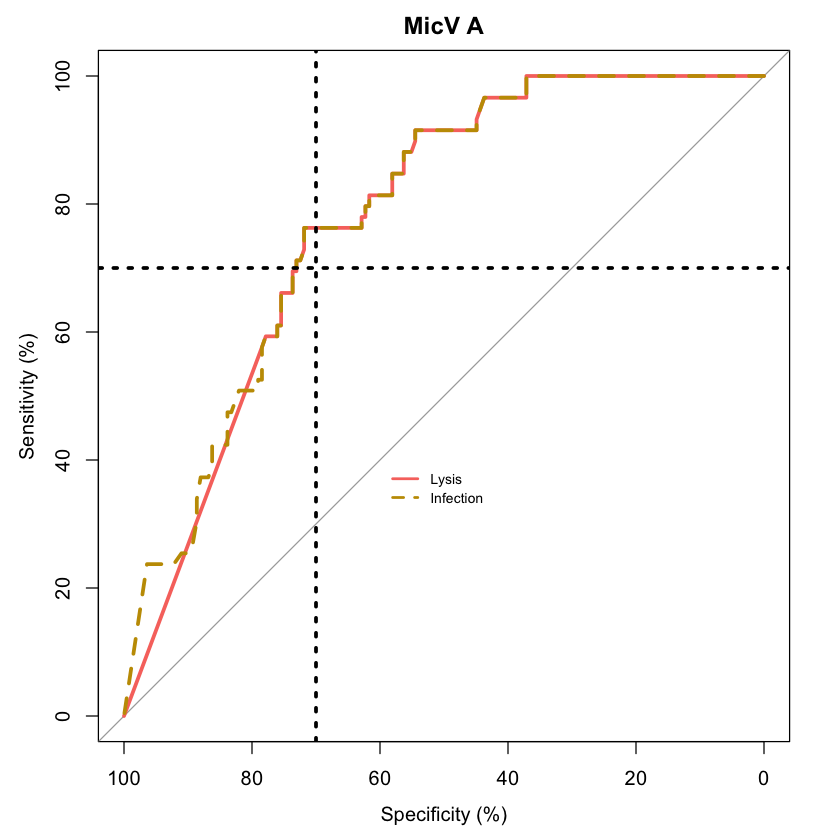

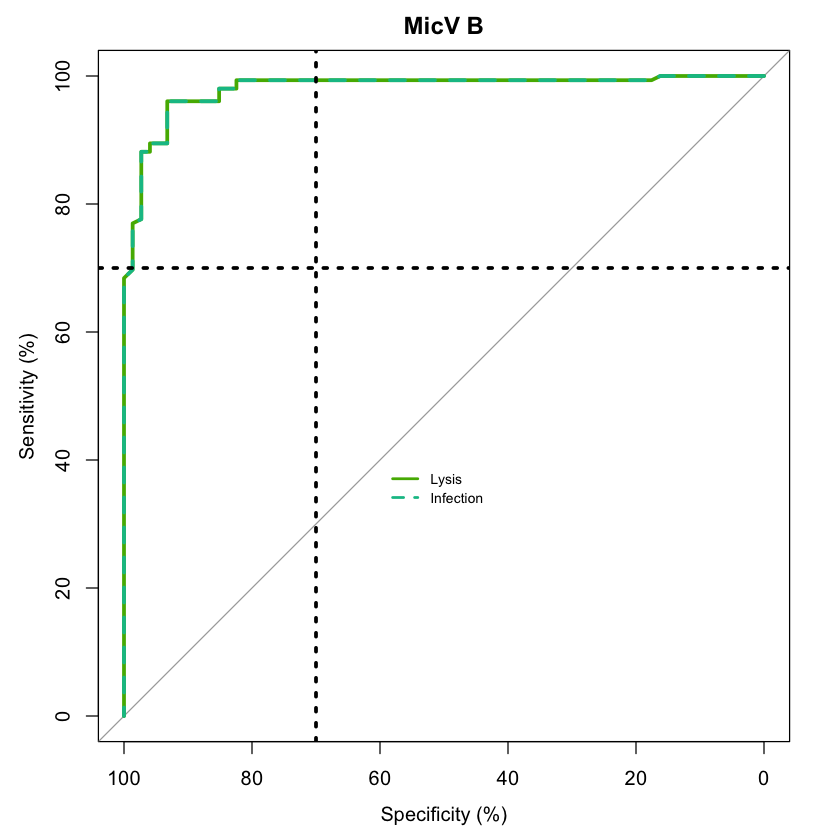

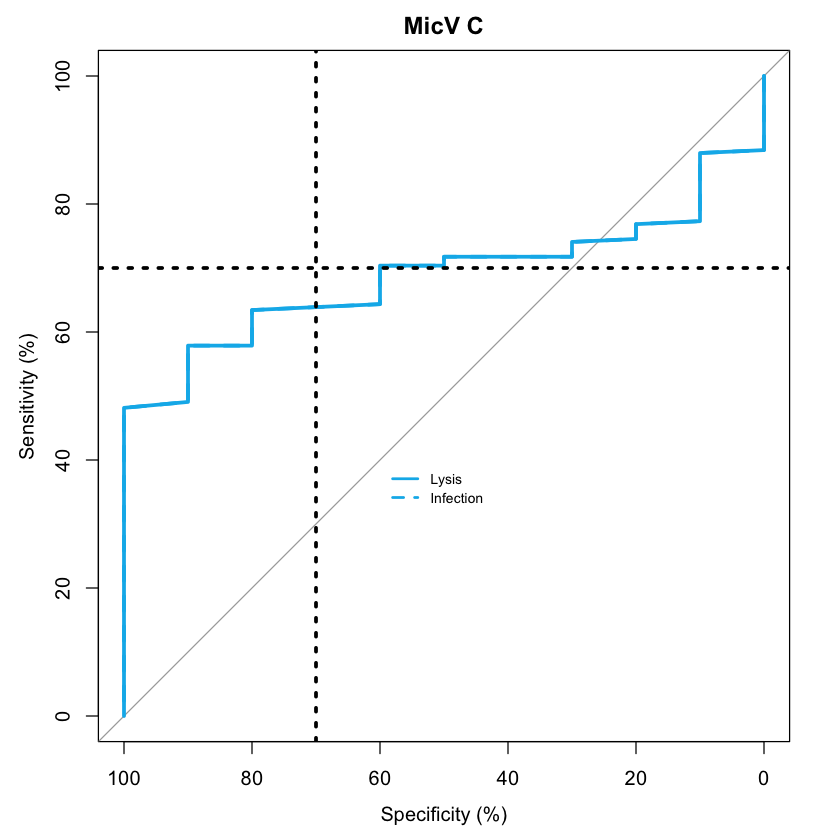

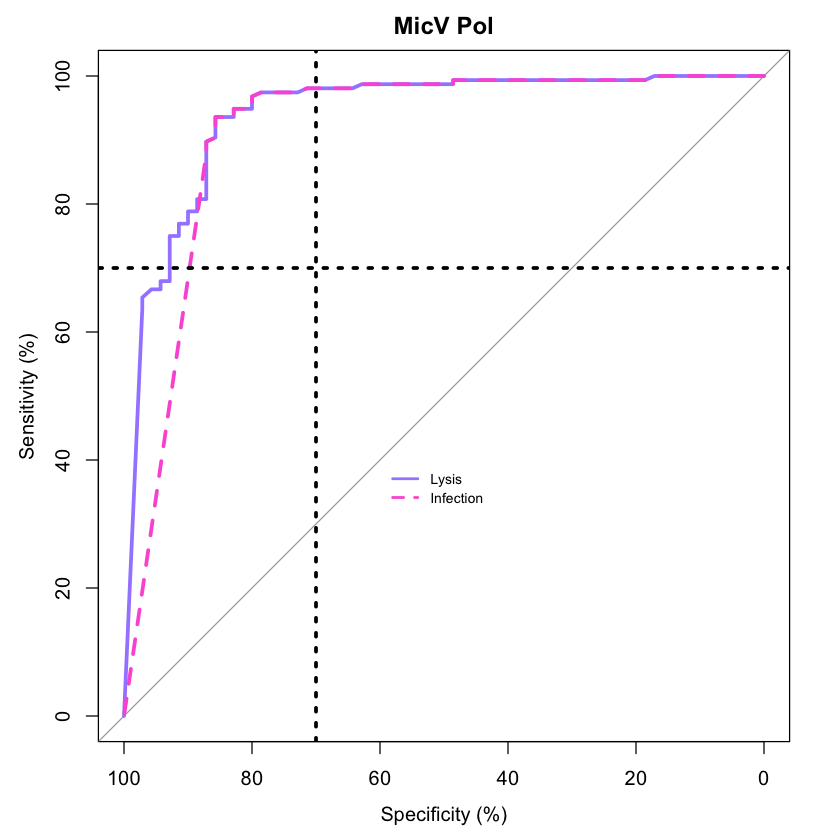

In [12]:
## Plot ROC curve

# Plot A
#pdf(file="./figures/figure4_roc_A.pdf",
#    width = 3, height = 3 , # Width and height in inches
#    bg = "white",            # Background color
#    colormodel = "rgb",      # Color model (cmyk is required for most publications)
#    paper = "USr")           # Paper size

plot(roc.obj.A.probaL,'col'="#F8766D",lwd=3, lty=1,cex.axis=1,cex.lab=1,main="MicV A")
lines(roc.obj.A.probaA,'col'="#C49A00",lwd=3, lty=2)
abline(h = 70, v = 70, col="black", lwd=3, lty=3)
legend(60, 40, legend=c("Lysis", "Infection"),col=c("#F8766D", "#C49A00"), lw=2.2, lty=1:2, cex=0.7,box.lty=0,text.font=1)

#dev.off()

# Plot B
#pdf(file="./figures/figure4_roc_B.pdf",
#    width = 3, height = 3 , # Width and height in inches
#    bg = "white",            # Background color
#    colormodel = "rgb",      # Color model (cmyk is required for most publications)
#    paper = "USr")           # Paper size

plot(roc.obj.B.probaL,'col'="#53B400",lwd=3, lty=1,cex.axis=1,cex.lab=1,main="MicV B")
lines(roc.obj.B.probaA,'col'="#00C094",lwd=3, lty=2)
abline(h = 70, v = 70, col="black", lwd=3, lty=3)
legend(60, 40, legend=c("Lysis", "Infection"),col=c("#53B400", "#00C094"), lw=2.2, lty=1:2, cex=0.7,box.lty=0,text.font=1)

#dev.off()

# Plot C
#pdf(file="./figures/figure4_roc_C.pdf",
#    width = 3, height = 3 , # Width and height in inches
#    bg = "white",            # Background color
#    colormodel = "rgb",      # Color model (cmyk is required for most publications)
#    paper = "USr")           # Paper size

plot(roc.obj.C.probaL,'col'="#00B6EB",lwd=3, lty=1,cex.axis=1,cex.lab=1,main="MicV C")
lines(roc.obj.C.probaA,'col'="#00B6EB",lwd=3, lty=2)
abline(h = 70, v = 70, col="black", lwd=3, lty=3)
legend(60, 40, legend=c("Lysis", "Infection"),col=c("#00B6EB", "#00B6EB"), lw=2.2, lty=1:2, cex=0.7,box.lty=0,text.font=1)

#dev.off()

# Plot Pol
#pdf(file="./figures/figure4_roc_Pol.pdf",
#    width = 3, height = 3 , # Width and height in inches
#    bg = "white",            # Background color
#    colormodel = "rgb",      # Color model (cmyk is required for most publications)
#    paper = "USr")           # Paper size

plot(roc.obj.Pol.probaL,'col'="#A58AFF",lwd=3, lty=1,cex.axis=1,cex.lab=1,,main="MicV Pol")
lines(roc.obj.Pol.probaA,'col'="#FB61D7",lwd=3, lty=2)
abline(h = 70, v = 70, col="black", lwd=3, lty=3)
legend(60, 40, legend=c("Lysis", "Infection"),col=c("#A58AFF", "#FB61D7"), lw=2.2, lty=1:2, cex=0.7,box.lty=0,text.font=1)

#dev.off()


### PLOT STAT TABLES

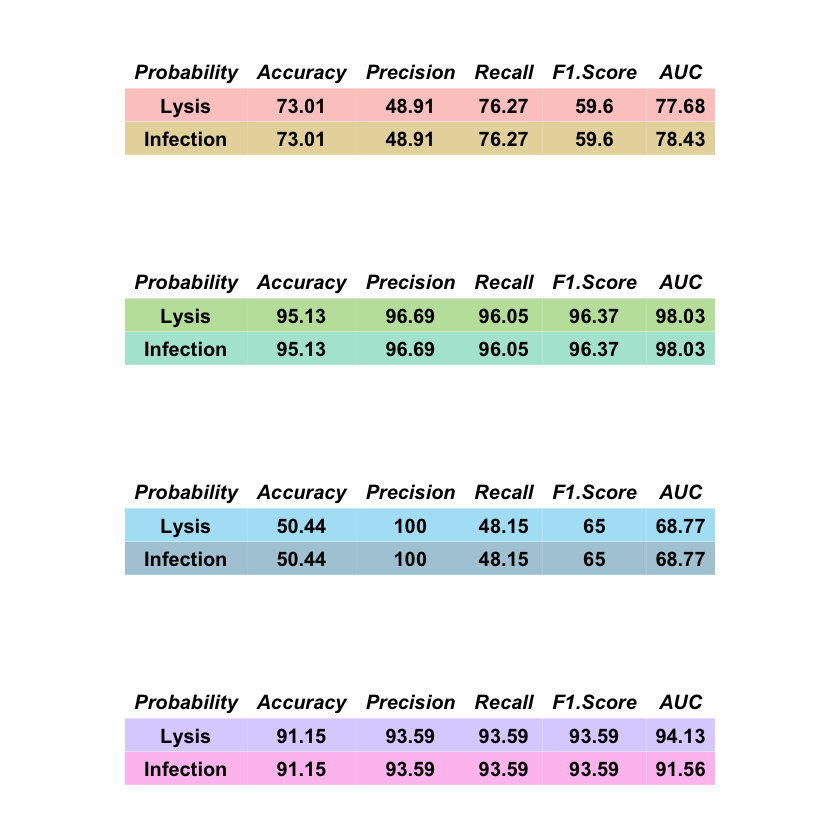

In [13]:
### PLOT TABLES FOR STATS
library(gtable)

# MicV A
ROC.plot.A <- ROC.STAT.A[-2,]
ROC.plot.A$parameters[1] <- "Lysis"
ROC.plot.A$parameters[2] <- "Infection"
ROC.plot.A[,2:6] <- round(ROC.plot.A[,2:6],2)
colnames(ROC.plot.A)[1] <- "Probability"

tt_A <- ttheme_minimal(
  core=list(bg_params = list(fill = c("#F8766D","#C49A00"),alpha=0.4, col=NA,rows = NULL),
            fg_params=list(fontface=2)),
  colhead=list(fg_params=list(col="black", fontface=4L)),
  rowhead=list(fg_params=list(col="orange", fontface=3L)))

# MicV B
ROC.plot.B <- ROC.STAT.B[-2,]
ROC.plot.B$parameters[1] <- "Lysis"
ROC.plot.B$parameters[2] <- "Infection"
ROC.plot.B[,2:6] <- round(ROC.plot.B[,2:6],2)
colnames(ROC.plot.B)[1] <- "Probability"

tt_B <- ttheme_minimal(
  core=list(bg_params = list(fill = c("#53B400","#00C094"),alpha=0.4, col=NA,rows = NULL),
            fg_params=list(fontface=2)),
  colhead=list(fg_params=list(col="black", fontface=4L)),
  rowhead=list(fg_params=list(col="orange", fontface=3L)))


# MicV C
ROC.plot.C <- ROC.STAT.C[-2,]
ROC.plot.C$parameters[1] <- "Lysis"
ROC.plot.C$parameters[2] <- "Infection"
ROC.plot.C[,2:6] <- round(ROC.plot.C[,2:6],2)
colnames(ROC.plot.C)[1] <- "Probability"

tt_C <- ttheme_minimal(
  core=list(bg_params = list(fill = c("#00B6EB","#00759c"),alpha=0.4, col=NA,rows = NULL),
            fg_params=list(fontface=2)),
  colhead=list(fg_params=list(col="black", fontface=4L)),
  rowhead=list(fg_params=list(col="orange", fontface=3L)))

# MicV POL
ROC.plot.Pol <- ROC.STAT.Pol[-2,]
ROC.plot.Pol$parameters[1] <- "Lysis"
ROC.plot.Pol$parameters[2] <- "Infection"
ROC.plot.Pol[,2:6] <- round(ROC.plot.Pol[,2:6],2)
colnames(ROC.plot.Pol)[1] <- "Probability"

tt_Pol <- ttheme_minimal(
  core=list(bg_params = list(fill = c("#A58AFF","#FB61D7"),alpha=0.4, col=NA,rows = NULL),
            fg_params=list(fontface=2)),
  colhead=list(fg_params=list(col="black", fontface=4L)),
  rowhead=list(fg_params=list(col="orange", fontface=3L)))

#pdf(file="./figures/figure4_roc_table.pdf",
#    width = 5, height = 5, # Width and height in inches
#    bg = "white",            # Background color
#    colormodel = "rgb",      # Color model (cmyk is required for most publications)
#    paper = "USr")           # Paper size

grid.arrange(
  tableGrob(ROC.plot.A, theme=tt_A, rows = NULL),
  tableGrob(ROC.plot.B, theme=tt_B, rows = NULL),
  tableGrob(ROC.plot.C, theme=tt_C, rows = NULL),
  tableGrob(ROC.plot.Pol, theme=tt_Pol, rows = NULL),
  nrow=4)

#dev.off()

### PLOT LOGISTIC CURVES

In [14]:
### Threshold
pL.thres.A = coords(roc.obj.A.probaL, x = "best", ret = "threshold")
pL.thres.B = coords(roc.obj.B.probaL, x = "best", ret = "threshold")
pL.thres.C = coords(roc.obj.C.probaL, x = "best", ret = "threshold")
pL.thres.Pol = coords(roc.obj.Pol.probaL, x = "best", ret = "threshold")

test = as.numeric(c(pL.thres.A,pL.thres.B,pL.thres.C,pL.thres.Pol))
summary(test)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.8086  0.8528  0.9019  0.8996  0.9488  0.9858 

In [15]:
## MicV.A
thre.A = coords(roc.obj.A.probaL, ret = c("threshold","sensitivity","specificity"))
thre.A = thre.A[thre.A$sensitivity >= 70,]
thre.A = thre.A[thre.A$specificity >= 70,]

TT = seq(-2,40,0.1);
modTT.A = Tdrivenf(TT,NaN,paraA)
pL.thres = max(coords(roc.obj.A.probaL, x = "best", ret = "threshold"))
TT.pL.thres = TT[round(modTT.A$probaL,2)==round(pL.thres,2)]
ci.up = min(TT[modTT.A$probaL*100 <= 100*round(thre.A[1,1],2)])
ci.low = min(TT[modTT.A$probaL*100 <= 100*round(thre.A[nrow(thre.A),1],2)])


pdf(file="./figures/figure5_ROC_thresh_A.pdf",
    width = 5, height = 5, # Width and height in inches
    bg = "white",            # Background color
    colormodel = "rgb",      # Color model (cmyk is required for most publications)
    paper = "USr")           # Paper size

# plot 
plot(T,MicV.A.Presence,pch=20,cex.axis=1.5,cex.lab=1.5,xlab="Temperature (C)",ylab="Probability",xlim=c(0,35))
lines(TT,modTT.A$probaL,'col'="#F8766D",lwd=3, lty=1)
abline(v = TT.pL.thres, col="#F8766D", lwd=3, lty=3)
#abline(v = min(TT[modTT.A$probaL*100 <= round(89.96,2)]), col="#F8766D", lwd=3, lty=4)
abline(v = max(TT[modTT.A$R0==1]), col="black", lwd=3, lty=3)
points(T,MicV.A.Presence,pch=20,cex=1.5)
legend(0, 0.5, legend=c("Data","Lysis","Thres. lysis","R0"),col=c("black","#F8766D","#F8766D","black"),
       pch=c(20,-1,-1,-1),lw=c(0,3,3,3),lty=c(0,1,2,2), cex=1.2,box.lty=0,text.font=1,bg="transparent")
text(TT.pL.thres-1.5,0.6,"T = 23.1",srt=90,cex=1.2,col="#F8766D")
text(max(TT[modTT.A$R0==1])+1.5,0.85,"T = 23.5",srt=90,cex=1.2,col="black")
rect(xleft = ci.low, xright = ci.up, ybottom = -1, ytop = 1.5, border = NA, col = adjustcolor("#F8766D", alpha = 0.2))

TT.pL.thres
dev.off()

Warning message in max(Chla, na.rm = TRUE):
“aucun argument pour max ; -Inf est renvoyé”


[1] 23.1

pdf 
  2

In [16]:
## MicV.B
thre.B = coords(roc.obj.B.probaL, ret = c("threshold","sensitivity","specificity"))
thre.B = thre.B[thre.B$sensitivity >= 80,]
thre.B = thre.B[thre.B$specificity >= 80,]

TT = seq(-2,40,0.1);
modTT.B = Tdrivenf(TT,NaN,paraB)
pL.thres = max(coords(roc.obj.B.probaL, x = "best", ret = "threshold"))
TT.pL.thres = TT[round(modTT.B$probaL,4)==round(pL.thres,4)]
ci.up = min(TT[modTT.B$probaL*100 <= 100*round(thre.B[1,1],2)])
ci.low = min(TT[modTT.B$probaL*100 <= 100*round(thre.B[nrow(thre.B),1],2)])

pdf(file="./figures/figure5_ROC_thresh_B.pdf",
    width = 5, height = 5, # Width and height in inches
    bg = "white",            # Background color
    colormodel = "rgb",      # Color model (cmyk is required for most publications)
    paper = "USr")           # Paper size

# plot
plot(T,MicV.B.Presence,pch=20,cex.axis=1.5,cex.lab=1.5,main="MicV B",xlab="Temperature (C)",ylab="Probability",xlim=c(0,35))
lines(TT,modTT.B$probaL,'col'="#53B400",lwd=3, lty=1)
abline(v = TT.pL.thres, col="#53B400", lwd=3, lty=3)
#abline(v = min(TT[modTT.B$probaL*100 <= round(89.96,2)]), col="#53B400", lwd=3, lty=4)
abline(v = max(TT[modTT.B$R0==1]), col="black", lwd=3, lty=3)
points(T,MicV.B.Presence,pch=20,cex=1.5)
legend(0, 0.5, legend=c("Data","Lysis","Thres. lysis","R0"),col=c("black","#53B400","#53B400","black"),
       pch=c(20,-1,-1,-1),lw=c(0,3,3,3),lty=c(0,1,2,2), cex=1.2,box.lty=0,text.font=1,bg="transparent")
text(TT.pL.thres-1.5,0.6,"T = 15.1",srt=90,cex=1.2,col="#53B400")
text(max(TT[modTT.B$R0==1])-1.5,0.6,"T = 27.4",srt=90,cex=1.2,col="black")
rect(xleft = ci.low, xright = ci.up, ybottom = -1, ytop = 1.5, border = NA, col = adjustcolor("#53B400", alpha = 0.2))
#roc.obj.B.probaL$ci

TT.pL.thres
#max(TT[modTT.B$R0==1])

dev.off()

Warning message in max(Chla, na.rm = TRUE):
“aucun argument pour max ; -Inf est renvoyé”


[1] 15.1

pdf 
  2

In [17]:
## MicV.C
thre.C = coords(roc.obj.C.probaL, ret = c("threshold","sensitivity","specificity"))
thre.C = thre.C[thre.C$sensitivity >= 50,]
thre.C = thre.C[thre.C$specificity >= 60,]

#thre.C

TT = seq(-2,40,0.1);
modTT.C = Tdrivenf(TT,NaN,paraC)
pL.thres = max(coords(roc.obj.C.probaL, x = "best", ret = "threshold"))
TT.pL.thres = min(TT[round(modTT.C$probaL,2)==round(pL.thres,2)])
ci.up = min(TT[modTT.C$probaL*100 <= 100*round(thre.C[1,1],2)])
ci.low = min(TT[modTT.C$probaL*100 <= 100*round(thre.C[nrow(thre.C),1],2)])

#pL.thres

pdf(file="./figures/figure5_ROC_thresh_C.pdf",
    width = 5, height = 5, # Width and height in inches
    bg = "white",            # Background color
    colormodel = "rgb",      # Color model (cmyk is required for most publications)
    paper = "USr")           # Paper size

# plot
plot(T,MicV.C.Presence,pch=20,cex.axis=1.5,cex.lab=1.5,main="MicV B",xlab="Temperature (C)",ylab="Probability",xlim=c(0,35))
lines(TT,modTT.C$probaL,'col'="#00B6EB",lwd=3, lty=1)
abline(v = TT.pL.thres, col="#00B6EB", lwd=3, lty=3)
#abline(v = min(TT[modTT.C$probaL*100 <= round(89.96,2)]), col="#00B6EB", lwd=3, lty=4)
abline(v = max(TT[modTT.C$R0==1]), col="black", lwd=3, lty=3)
points(T,MicV.C.Presence,pch=20,cex=1.5)
legend(0, 0.5, legend=c("Data","Lysis","Thres. lysis","R0"),col=c("black","#00B6EB","#00B6EB","black"),
       pch=c(20,-1,-1,-1),lw=c(0,3,3,3),lty=c(0,1,2,2), cex=1.2,box.lty=0,text.font=1,bg="transparent")
text(TT.pL.thres-1,0.6,"T = 21.2",srt=90,cex=1.2,col="#00B6EB")
text(max(TT[modTT.C$R0==1])+1,0.85,"T = 25.6",srt=90,cex=1.2,col="black")
rect(xleft = ci.low, xright = ci.up, ybottom = -1, ytop = 1.5, border = NA, col = adjustcolor("#00B6EB", alpha = 0.2))

TT.pL.thres

dev.off()

Warning message in max(Chla, na.rm = TRUE):
“aucun argument pour max ; -Inf est renvoyé”


[1] 21.2

pdf 
  2

In [18]:
## MicV.Pol
thre.Pol = coords(roc.obj.Pol.probaL, ret = c("threshold","sensitivity","specificity"))
thre.Pol = thre.Pol[thre.Pol$sensitivity >= 80,]
thre.Pol = thre.Pol[thre.Pol$specificity >= 80,]

TT = seq(-2,40,0.1);
modTT.Pol = Tdrivenf(TT,NaN,paraPol)
pL.thres = max(coords(roc.obj.Pol.probaL, x = "best", ret = "threshold"))
TT.pL.thres = min(TT[round(modTT.Pol$probaL,2)==round(pL.thres,2)])
ci.up = min(TT[modTT.Pol$probaL*100 <= 100*round(thre.Pol[1,1],2)])
ci.low = min(TT[modTT.Pol$probaL*100 <= 100*round(thre.Pol[nrow(thre.Pol),1],2)])

pdf(file="./figures/figure5_ROC_thresh_Pol.pdf",
    width = 5, height = 5, # Width and height in inches
    bg = "white",            # Background color
    colormodel = "rgb",      # Color model (cmyk is required for most publications)
    paper = "USr")           # Paper size

# plot
plot(T,MicV.Pol.Presence,pch=20,cex.axis=1.5,cex.lab=1.5,xlab="Temperature (C)",ylab="Probability",xlim=c(0,35))
lines(TT,modTT.Pol$probaL,'col'="#A58AFF",lwd=3, lty=1)
abline(v = TT.pL.thres, col="#A58AFF", lwd=3, lty=3)
abline(v = max(TT[modTT.Pol$R0==1]), col="black", lwd=3, lty=3)
#abline(v = min(TT[modTT.Pol$probaL*100 <= round(89.96,2)]), col="#A58AFF", lwd=3, lty=4)
points(T,MicV.Pol.Presence,pch=20,cex=1.5)
legend(19.75, 0.95, legend=c("Data","Lysis","Thres. lysis","R0"),col=c("black","#A58AFF","#A58AFF","black"),
       pch=c(20,-1,-1,-1),lw=c(0,3,3,3),lty=c(0,1,2,2), cex=1.2,box.lty=0,text.font=1,bg="transparent")
text(TT.pL.thres-1,0.6,"T = 13.9",srt=90,cex=1.2,col="#A58AFF")
text(max(TT[modTT.Pol$R0==1])-1.5,0.6,"T = 10.3",srt=90,cex=1.2,col="black")
rect(xleft = ci.low, xright = ci.up, ybottom = -1, ytop = 1.5, border = NA, col = adjustcolor("#A58AFF", alpha = 0.2))

TT.pL.thres

dev.off()

Warning message in max(Chla, na.rm = TRUE):
“aucun argument pour max ; -Inf est renvoyé”


[1] 13.9

pdf 
  2

### PLOT FREQUENCIES OF TRUE AND FALSE SAMPLES

In [19]:
## MicV A
matlab.A <- data.frame("lat"=MicV.A$Latitude,"lon"=MicV.A$Longitude,"T"=MicV.A$Temperature,"Presence"=as.numeric(MicV.A.Presence))

Tp.Pol = 23.1
matlab.A$model[matlab.A$T <= Tp.Pol] = 1
matlab.A$model[matlab.A$T > Tp.Pol] = 0

matlab.A = na.omit(matlab.A)

matlab.A$diff = matlab.A$model - matlab.A$Presence
matlab.A$ROC[matlab.A$diff == -1] = "FN"
matlab.A$ROC[matlab.A$diff == 1] = "FP"
matlab.A$ROC[matlab.A$diff == 0 & matlab.A$Presence == 1] = "TP"
matlab.A$ROC[matlab.A$diff == 0 & matlab.A$Presence == 0] = "TN"
matlab.A$Prediction[matlab.A$diff == 0] = "True"
matlab.A$Prediction[matlab.A$diff != 0] = "False"

#matlab.A

prop.A = data.frame("ROC" = c("TP","TN","FP","FN"))
prop.A$p[1] = 100*length(matlab.A$ROC[matlab.A$ROC=="TP"])/length(matlab.A$ROC)
prop.A$p[2] = 100*length(matlab.A$ROC[matlab.A$ROC=="TN"])/length(matlab.A$ROC)
prop.A$p[3] = 100*length(matlab.A$ROC[matlab.A$ROC=="FP"])/length(matlab.A$ROC)
prop.A$p[4] = 100*length(matlab.A$ROC[matlab.A$ROC=="FN"])/length(matlab.A$ROC)
# Add label position
prop.A <- prop.A %>%
  arrange(desc(ROC)) %>%
  mutate(lab.ypos = cumsum(p) - 0.5*p)
#prop.A

#prop.A
mycols <- c("#ffd966", "#f37736", "#0392cf","#7bc043")

pdf(file="./figures/figure5_ROC_freq_A.pdf",
    width = 5, height = 5, # Width and height in inches
    bg = "white",            # Background color
    colormodel = "rgb",      # Color model (cmyk is required for most publications)
    paper = "USr")           # Paper size

ggplot(prop.A, aes(x = "", y = p, fill = ROC)) +
  geom_bar(width = 1, stat = "identity", color = "white") +
  coord_polar("y", start = 0)+
  geom_text(aes(y = lab.ypos, label = round(p,1)), color = "black",cex=10)+
  scale_fill_manual(values = mycols) +
  theme_void()

write.csv(matlab.A, "./data/matlab.A.csv", row.names=FALSE)
dev.off()

length(matlab.A$ROC)

pdf 
  2

[1] 226

In [20]:
## MicV B
matlab.B <- data.frame("lat"=MicV.B$Latitude,"lon"=MicV.B$Longitude,"T"=MicV.B$Temperature,"Presence"=as.numeric(MicV.B.Presence))

Tp.B = 15.1
matlab.B$model[matlab.B$T <= Tp.B] = 1
matlab.B$model[matlab.B$T > Tp.B] = 0

matlab.B = na.omit(matlab.B)

matlab.B$diff = matlab.B$model - matlab.B$Presence
matlab.B$ROC[matlab.B$diff == -1] = "FN"
matlab.B$ROC[matlab.B$diff == 1] = "FP"
matlab.B$ROC[matlab.B$diff == 0 & matlab.B$Presence == 1] = "TP"
matlab.B$ROC[matlab.B$diff == 0 & matlab.B$Presence == 0] = "TN"
matlab.B$Prediction[matlab.B$diff == 0] = "True"
matlab.B$Prediction[matlab.B$diff != 0] = "False"

prop.B = data.frame("ROC" = c("TP","TN","FP","FN"))
prop.B$p[1] = 100*length(matlab.B$ROC[matlab.B$ROC=="TP"])/length(matlab.B$ROC)
prop.B$p[2] = 100*length(matlab.B$ROC[matlab.B$ROC=="TN"])/length(matlab.B$ROC)
prop.B$p[3] = 100*length(matlab.B$ROC[matlab.B$ROC=="FP"])/length(matlab.B$ROC)
prop.B$p[4] = 100*length(matlab.B$ROC[matlab.B$ROC=="FN"])/length(matlab.B$ROC)
# Add label position
prop.B <- prop.B %>%
  arrange(desc(ROC)) %>%
  mutate(lab.ypos = cumsum(p) - 0.5*p)
prop.B$lab.ypos[3]=90
prop.B$lab.ypos[4]=4

#prop.A
mycols <- c("#ffd966", "#f37736", "#0392cf","#7bc043")

pdf(file="./figures/figure5_ROC_freq_B.pdf",
    width = 5, height = 5, # Width and height in inches
    bg = "white",            # Background color
    colormodel = "rgb",      # Color model (cmyk is required for most publications)
    paper = "USr")           # Paper size

ggplot(prop.B, aes(x = "", y = p, fill = ROC)) +
  geom_bar(width = 1, stat = "identity", color = "white") +
  coord_polar("y", start = 0)+
  geom_text(aes(y = lab.ypos, label = round(p,1)), color = "black",cex=10)+
  scale_fill_manual(values = mycols) +
  theme_void()

write.csv(matlab.B, "./data/matlab.B.csv", row.names=FALSE)

dev.off()

length(matlab.B$ROC)
length(matlab.B$Presence[matlab.B$Presence == 1])

pdf 
  2

[1] 226

[1] 74

In [21]:
## MicV C
matlab.C <- data.frame("lat"=MicV.C$Latitude,"lon"=MicV.C$Longitude,"T"=MicV.C$Temperature,"Presence"=as.numeric(MicV.C.Presence))

Tp.C = 21.2
matlab.C$model[matlab.C$T <= Tp.C] = 1
matlab.C$model[matlab.C$T > Tp.C] = 0

matlab.C = na.omit(matlab.C)

matlab.C$diff = matlab.C$model - matlab.C$Presence
matlab.C$ROC[matlab.C$diff == -1] = "FN"
matlab.C$ROC[matlab.C$diff == 1] = "FP"
matlab.C$ROC[matlab.C$diff == 0 & matlab.C$Presence == 1] = "TP"
matlab.C$ROC[matlab.C$diff == 0 & matlab.C$Presence == 0] = "TN"
matlab.C$Prediction[matlab.C$diff == 0] = "True"
matlab.C$Prediction[matlab.C$diff != 0] = "False"

prop.C = data.frame("ROC" = c("TP","TN","FP","FN"))
prop.C$p[1] = 100*length(matlab.C$ROC[matlab.C$ROC=="TP"])/length(matlab.C$ROC)
prop.C$p[2] = 100*length(matlab.C$ROC[matlab.C$ROC=="TN"])/length(matlab.C$ROC)
prop.C$p[3] = 100*length(matlab.C$ROC[matlab.C$ROC=="FP"])/length(matlab.C$ROC)
prop.C$p[4] = 100*length(matlab.C$ROC[matlab.C$ROC=="FN"])/length(matlab.C$ROC)
# Add label position
prop.C <- prop.C %>%
  arrange(desc(ROC)) %>%
  mutate(lab.ypos = cumsum(p) - 0.5*p)
prop.C$lab.ypos[1]=90
prop.C$lab.ypos[4]=4

prop.C
mycols <- c("#ffd966", "#f37736", "#0392cf","#7bc043")

pdf(file="./figures/figure5_ROC_freq_C.pdf",
    width = 5, height = 5, # Width and height in inches
    bg = "white",            # Background color
    colormodel = "rgb",      # Color model (cmyk is required for most publications)
    paper = "USr")           # Paper size

ggplot(prop.C, aes(x = "", y = p, fill = ROC)) +
  geom_bar(width = 1, stat = "identity", color = "white") +
  coord_polar("y", start = 0)+
  geom_text(aes(y = lab.ypos, label = round(p,1)), color = "black",cex=10)+
  scale_fill_manual(values = mycols) +
  theme_void()

dev.off()

write.csv(matlab.C, "./data/matlab.C.csv", row.names=FALSE)

length(matlab.C$ROC)
length(matlab.C$Presence[matlab.C$Presence == 1])

ROC,p,lab.ypos
<chr>,<dbl>,<dbl>
TP,3.9823009,90.00000
TN,47.7876106,27.87611
FP,47.7876106,75.66372
FN,0.4424779,4.00000


pdf 
  2

[1] 226

[1] 10

In [22]:
## MicV POl
matlab.Pol <- data.frame("lat"=MicV.Pol$Latitude,"lon"=MicV.Pol$Longitude,"T"=MicV.Pol$Temperature,"Presence"=as.numeric(MicV.Pol.Presence))

Tp.Pol = 13.9
matlab.Pol$model[matlab.Pol$T <= Tp.Pol] = 1
matlab.Pol$model[matlab.Pol$T > Tp.Pol] = 0

matlab.Pol = na.omit(matlab.Pol)

matlab.Pol$diff = matlab.Pol$model - matlab.Pol$Presence
matlab.Pol$ROC[matlab.Pol$diff == -1] = "FN"
matlab.Pol$ROC[matlab.Pol$diff == 1] = "FP"
matlab.Pol$ROC[matlab.Pol$diff == 0 & matlab.Pol$Presence == 1] = "TP"
matlab.Pol$ROC[matlab.Pol$diff == 0 & matlab.Pol$Presence == 0] = "TN"
matlab.Pol$Prediction[matlab.Pol$diff == 0] = "True"
matlab.Pol$Prediction[matlab.Pol$diff != 0] = "False"

prop.Pol = data.frame("ROC" = c("TP","TN","FP","FN"))
prop.Pol$p[1] = 100*length(matlab.Pol$ROC[matlab.Pol$ROC=="TP"])/length(matlab.Pol$ROC)
prop.Pol$p[2] = 100*length(matlab.Pol$ROC[matlab.Pol$ROC=="TN"])/length(matlab.Pol$ROC)
prop.Pol$p[3] = 100*length(matlab.Pol$ROC[matlab.Pol$ROC=="FP"])/length(matlab.Pol$ROC)
prop.Pol$p[4] = 100*length(matlab.Pol$ROC[matlab.Pol$ROC=="FN"])/length(matlab.Pol$ROC)
# Add label position
prop.Pol <- prop.Pol %>%
  arrange(desc(ROC)) %>%
  mutate(lab.ypos = cumsum(p) - 0.5*p)
#prop.Pol

#prop.Pol
mycols <- c("#ffd966", "#f37736", "#0392cf","#7bc043")

pdf(file="./figures/figure5_ROC_freq_Pol.pdf",
    width = 5, height = 5, # Width and height in inches
    bg = "white",            # Background color
    colormodel = "rgb",      # Color model (cmyk is required for most publications)
    paper = "USr")           # Paper size

ggplot(prop.Pol, aes(x = "", y = p, fill = ROC)) +
  geom_bar(width = 1, stat = "identity", color = "white") +
  coord_polar("y", start = 0)+
  geom_text(aes(y = lab.ypos, label = round(p,1)), color = "black",cex=10)+
  scale_fill_manual(values = mycols) +
  theme_void()

dev.off()

write.csv(matlab.Pol, "./data/matlab.Pol.csv", row.names=FALSE)

length(matlab.Pol$ROC)
length(matlab.Pol$Presence[matlab.Pol$Presence == 1])

pdf 
  2

[1] 226

[1] 70